In [4]:
pip install census pandas geopandas folium matplotlib

Note: you may need to restart the kernel to use updated packages.


In [32]:
import pandas as pd
import requests
import numpy as np
from census import Census

# Census API Key
CENSUS_API_KEY = "ba4ebb1e4370c4c8fedcf8ee302d583d8cb65d15"
c = Census(CENSUS_API_KEY, year=2021)  # Use ACS 5-Year Data

In [28]:
variables = {
    "B19013_001E": "Median_Income",   
}

# Extract block group level data 
block_group_data = c.acs5.state_county_blockgroup(
    list(variables.keys()),  # Variables
    state_fips="47",  # Tennessee
    county_fips="157",  # Shelby County
    blockgroup="*",  # All block groups
    tract="*"  # All tracts
)



# Convert to DataFrame
df_block_group = pd.DataFrame(block_group_data)

# Rename columns
df_block_group.rename(columns=variables, inplace=True)

# Construct GEOID
df_block_group["GEOID"] = (
    df_block_group["state"] + 
    df_block_group["county"] + 
    df_block_group["tract"] + 
    df_block_group["block group"]
)


# Check the dataframe
print(df_block_group.head())

   Median_Income state county   tract block group         GEOID
0        72404.0    47    157  000100           1  471570001001
1        65556.0    47    157  000100           2  471570001002
2        98788.0    47    157  000100           3  471570001003
3        21354.0    47    157  000200           1  471570002001
4        25375.0    47    157  000300           1  471570003001


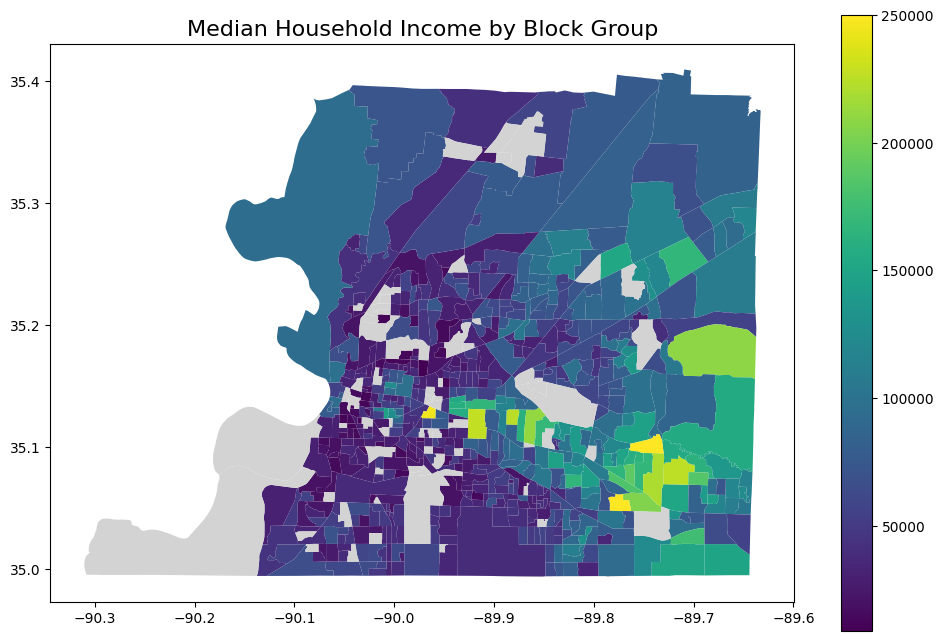

In [34]:
import geopandas as gpd
import folium
import matplotlib.pyplot as plt

# Load block group shapefile for Shelby County
block_groups = gpd.read_file("\\Users\\gmwil\\OneDrive\\Desktop\\Coding Work\\Python Files\\tl_2021_47_bg\\tl_2021_47_bg.shp")
block_groups = block_groups[block_groups["COUNTYFP"] == "157"]  # Shelby County

# Replace placeholders
df_block_group["Median_Income"] = df_block_group["Median_Income"].replace(-666666666, np.nan)

# Merge with block group shapefile
block_groups_merged = block_groups.merge(
    df_block_group, 
    left_on="GEOID", 
    right_on="GEOID", 
    how="left"
)

fig, ax = plt.subplots(1, 1, figsize=(12, 8))
block_groups_merged.plot(
    column="Median_Income", 
    cmap="viridis",  
    legend=True, 
    ax=ax,
    missing_kwds={"color": "lightgrey"}  
)

ax.set_title("Median Household Income by Block Group", fontsize=16)

plt.show()

In [46]:
# Load the census tract shapefile
tracts = gpd.read_file("\\Users\\gmwil\\OneDrive\\Desktop\\Coding Work\\Python Files\\tl_2021_47_tract\\tl_2021_47_tract.shp")

# Filter for Shelby County (FIPS code: 157)
tracts = tracts[tracts["COUNTYFP"] == "157"]

# Check the first few rows
print(tracts.head())
# Define variables to extract
variables = {
    "B01003_001E": "Total_Population",  
    "B19013_001E": "Median_Income",     
    "B17001_002E": "Below_Poverty",     
    "B17001_001E": "Poverty_Universe"   
}

# Tract-level data for Shelby County 
tract_data = c.acs5.state_county_tract(
    list(variables.keys()),  
    state_fips="47",  
    county_fips="157",  
    tract="*"  
)

# Convert to DataFrame
df_tract = pd.DataFrame(tract_data)

# Rename columns
df_tract.rename(columns=variables, inplace=True)

# Construct GEOID
df_tract["GEOID"] = df_tract["state"] + df_tract["county"] + df_tract["tract"]

# Drop unnecessary columns
df_tract.drop(columns=["state", "county", "tract"], inplace=True)

# Calculate Poverty Rate
df_tract["Poverty_Rate"] = (
    df_tract["Below_Poverty"] / df_tract["Poverty_Universe"] * 100
)

# Merge poverty rate data with tract shapefile
tracts_merged = tracts.merge(
    df_tract, 
    left_on="GEOID", 
    right_on="GEOID", 
    how="left"
)

print(tracts_merged.head())

   STATEFP COUNTYFP TRACTCE        GEOID    NAME             NAMELSAD  MTFCC  \
15      47      157  009700  47157009700      97      Census Tract 97  G5020   
16      47      157  009800  47157009800      98      Census Tract 98  G5020   
18      47      157  021420  47157021420  214.20  Census Tract 214.20  G5020   
19      47      157  021430  47157021430  214.30  Census Tract 214.30  G5020   
20      47      157  021754  47157021754  217.54  Census Tract 217.54  G5020   

   FUNCSTAT    ALAND  AWATER     INTPTLAT      INTPTLON  \
15        S  1797643       0  +35.0821716  -089.9098811   
16        S  3600199       0  +35.1588793  -089.8968834   
18        S  4281893       0  +35.1066931  -089.8135329   
19        S  4029806       0  +35.0877923  -089.8220400   
20        S  2599627       0  +35.0130818  -089.8398678   

                                             geometry  
15  POLYGON ((-89.92323 35.07884, -89.92322 35.078...  
16  POLYGON ((-89.90615 35.14876, -89.90614 35.149..

In [51]:
# Create a base map centered on Shelby County
m = folium.Map(location=[35.1495, -90.0490], zoom_start=10)


folium.Choropleth(
    geo_data=tracts_merged, 
    name="Poverty Rate",
    data=tracts_merged,  
    columns=["GEOID", "Poverty_Rate"], 
    key_on="feature.properties.GEOID",  
    fill_color="viridis",  #
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name="Poverty Rate (%)",  
    bins=[0, 5, 10, 15, 20, 40, 60, 80],  
    highlight=True,
).add_to(m)

# Add hover functionality
folium.features.GeoJson(
    tracts_merged,
    name="Poverty Rate",
    style_function=lambda x: {"fillColor": "transparent", "color": "black", "weight": 0.5},
    tooltip=folium.features.GeoJsonTooltip(
        fields=["GEOID", "Poverty_Rate"],
        aliases=["Tract ID", "Poverty Rate"],
        localize=True,
    ),
).add_to(m)

# Add layer control
folium.LayerControl().add_to(m)

# Display the map
m.save("poverty_rate_map.html")  # Save to an HTML file
m  # Display in the notebook